## Objective
Goal here is to extract information quickly using various NLP tools from quarterly call earning transcripts of various tech companies. Some exploratory data analysis to understand the topics being discussed during the earnings calls and sentiment trends.

## What are call earning transcripts?
On the day of the earnings release by public listed companies, the companies old earnings call with the investor analysts. These calls are recorded and uploaded in audio on companies investor filing section. 

## Where can one get earning call in a machine readable format?
There are multiple ways to get this information. One can use actual recordings (or live call) and translate it into text using machine learning tool / apis.

The earnings call is also transcripted into text and available on various websites like www.fool.com. 

I have downloaded this transcript from fool.com using BeautifulSoup api.

## Exactly what NLP analysis will be done here?
- TF-IDF to determine the extract new topics discsussed in each call
- Topic Modelling using Gensim
- Higlighting sentiment trends using [Loughran McDonald Sentiment Word Lists](https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists)


### Loughran McDonald Sentiment Word Lists
We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining


## Which libraries are going to be used for NLP analysis
- [Spacy](https://spacy.io/). All NLP has been done using Spacy as opposed to NLTK (NLTK is slow, and in my opinion a bit old school ;))
- [Gensim](https://radimrehurek.com/gensim/)
- BeautifulSoup, WordCloud and other python libraries

## Inspiration
I came across  "Loughran McDonald Sentiment Word Lists" during my Udacity course `AI for Trading`. I highly recommend this course for the large practical knowldge the course provided. In the course sentiment analysis was performed on 10-K statements and then further used to create factors into a model.

In [1]:
import sys
from bs4 import BeautifulSoup
from datetime import datetime
import requests
from ratelimit import limits, sleep_and_retry
import pandas as pd
import re
from pathlib import Path
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel
%matplotlib inline

In [ ]:
# download the spacy model

## enable this for downloading smaller spacy model
#!{sys.executable} -m spacy download en 

## enable this for downloading medium spacy model
!{sys.executable} -m spacy download en_core_web_md

In [2]:
## enable this for using smaller spacy model
# spacy_model = 'en' 

## enable this for using medium spacy model
spacy_model = 'en_core_web_md'

In [3]:
nlp = spacy.load(spacy_model)

In [4]:
columns = ['ticker','quarter', 'year', 'url']
data = [
    ['GOOG','q2', 2020, 'https://www.fool.com/earnings/call-transcripts/2020/07/31/alphabet-inc-goog-googl-q2-2020-earnings-call-tran.aspx'],
    ['GOOG','q1', 2020, 'https://www.fool.com/earnings/call-transcripts/2020/04/29/alphabet-inc-goog-googl-q1-2020-earnings-call-tran.aspx'],
    ['GOOG','q4', 2019, 'https://www.fool.com/earnings/call-transcripts/2020/02/03/alphabet-inc-goog-googl-q4-2019-earnings-call-tran.aspx'],
    ['GOOG','q3', 2019, 'https://www.fool.com/earnings/call-transcripts/2019/10/29/google-inc-googl-q3-2019-earnings-call-transcript.aspx'],

    ['AMZN','q2', 2020, 'https://www.fool.com/earnings/call-transcripts/2020/07/31/amazon-amzn-q2-2020-earnings-call-transcript.aspx'],
    ['AMZN','q1', 2020, 'https://www.fool.com/earnings/call-transcripts/2020/04/30/amazoncom-inc-amzn-q1-2020-earnings-call-transcrip.aspx'],
    ['AMZN','q4', 2019, 'https://www.fool.com/earnings/call-transcripts/2020/01/31/amazoncom-inc-amzn-q4-2019-earnings-call-transcrip.aspx'],
    ['AMZN','q3', 2019, 'https://www.fool.com/earnings/call-transcripts/2019/10/24/amazoncom-inc-amzn-q3-2019-earnings-call-transcrip.aspx'],

    ['FB','q2', 2020, 'https://www.fool.com/earnings/call-transcripts/2020/07/31/facebook-fb-q2-2020-earnings-call-transcript.aspx'],
    ['FB','q1', 2020, 'https://www.fool.com/earnings/call-transcripts/2020/04/29/facebook-inc-fb-q1-2020-earnings-call-transcript.aspx'],
    ['FB','q4', 2019, 'https://www.fool.com/earnings/call-transcripts/2020/01/29/facebook-inc-fb-q4-2019-earnings-call-transcript.aspx'],
    ['FB','q3', 2019, 'https://www.fool.com/earnings/call-transcripts/2019/10/31/facebook-inc-fb-q3-2019-earnings-call-transcript.aspx'],

    ['MSFT','q2', 2020, 'https://www.fool.com/earnings/call-transcripts/2020/07/23/microsoft-msft-q4-2020-earnings-call-transcript.aspx'],
    ['MSFT','q1', 2020, 'https://www.fool.com/earnings/call-transcripts/2020/04/30/microsoft-corp-msft-q3-2020-earnings-call-transcri.aspx'],
    ['MSFT','q4', 2019, 'https://www.fool.com/earnings/call-transcripts/2019/07/18/microsoft-corp-msft-q4-2019-earnings-call-transcri.aspx'],
    ['MSFT','q3', 2019, 'https://www.fool.com/earnings/call-transcripts/2019/04/25/microsoft-corp-msft-q3-2019-earnings-call-transcri.aspx'],
]
df = pd.DataFrame(data=data, columns=columns)

In [5]:
df['call_date'] = df['url'].apply(lambda x : pd.to_datetime(re.match(r".*(\d{4}/\d{2}/\d{2})", x).group(1)))

In [6]:
download_dir = Path("./downloads")
ticker='GOOG'

In [7]:
def download_transripts(df_row):
    local_path = download_dir / Path(df_row['ticker'] + '-' + df_row['quarter'] + '-' + str(df_row['year']) + '.html')
    if local_path.is_file():
        print(f"File Exists {local_path}")
    else:
        print(f"Downloading {df_row['ticker']}, url: {df_row['url']}")
        url_get =  requests.get(df_row['url'])
        soup = BeautifulSoup(url_get.text)
        with open(local_path,'w') as fh:
                fh.write(str(soup)) 
    return local_path

In [8]:
df['local_path'] = df.apply(download_transripts, axis=1)

File Exists downloads/GOOG-q2-2020.html
File Exists downloads/GOOG-q1-2020.html
File Exists downloads/GOOG-q4-2019.html
File Exists downloads/GOOG-q3-2019.html
File Exists downloads/AMZN-q2-2020.html
File Exists downloads/AMZN-q1-2020.html
File Exists downloads/AMZN-q4-2019.html
File Exists downloads/AMZN-q3-2019.html
File Exists downloads/FB-q2-2020.html
File Exists downloads/FB-q1-2020.html
File Exists downloads/FB-q4-2019.html
File Exists downloads/FB-q3-2019.html
File Exists downloads/MSFT-q2-2020.html
File Exists downloads/MSFT-q1-2020.html
File Exists downloads/MSFT-q4-2019.html
File Exists downloads/MSFT-q3-2019.html


In [9]:
def get_transcript_text(df_row):
    local_path = download_dir / Path(df_row['ticker'] + '-' + df_row['quarter'] + '-' + str(df_row['year']) + '.txt')
    if local_path.is_file():
        print(f"File Exists {local_path}")
        with open(local_path, "r") as fh:
            plain_text = fh.read()
        return plain_text      
    else:
        print(f"Processing {df_row['local_path']}")
        with open(df_row['local_path'], "r") as fh:
            html = fh.read()
        regex = re.compile(r'Prepared Remarks:\s*(\n*.*)\s*Call participants:',re.DOTALL)
        matches = regex.finditer(html)
        plain_text=''
        for match in matches:
            # print(match)
            plain_text = BeautifulSoup(match.group(1), 'html.parser').get_text() # remove all the html

        with open(local_path,'w') as fh:
                fh.write(plain_text) 
        return plain_text

In [10]:
df['plain_text'] = df.apply(get_transcript_text, axis=1)

File Exists downloads/GOOG-q2-2020.txt
File Exists downloads/GOOG-q1-2020.txt
File Exists downloads/GOOG-q4-2019.txt
File Exists downloads/GOOG-q3-2019.txt
File Exists downloads/AMZN-q2-2020.txt
File Exists downloads/AMZN-q1-2020.txt
File Exists downloads/AMZN-q4-2019.txt
File Exists downloads/AMZN-q3-2019.txt
File Exists downloads/FB-q2-2020.txt
File Exists downloads/FB-q1-2020.txt
File Exists downloads/FB-q4-2019.txt
File Exists downloads/FB-q3-2019.txt
File Exists downloads/MSFT-q2-2020.txt
File Exists downloads/MSFT-q1-2020.txt
File Exists downloads/MSFT-q4-2019.txt
File Exists downloads/MSFT-q3-2019.txt


In [119]:
additional_stop_words = ['operator', 'financial', 'officer', 'chief', 'executive', 'think', \
                         'google', 'facebook', 'amazon', 'microsoft', 'thank', 'you', 'quarter', 'see', \
                        'business', 'customer', 'growth', 'revenue', 'year', 'question'] 

for stopword in additional_stop_words:
    nlp.vocab[stopword].is_stop = True

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [143]:
def get_lemmatized_words(df_row):
    print(f"Processing {df_row['ticker']}, quarter: {df_row['quarter']}, year: {df_row['year']}")
    words = []
    doc = nlp(df_row['plain_text'].lower())
    for word in doc:
        # print(word)
        
        #if word.is_alpha and word.is_ascii and not word.is_stop and \
        #    word.pos_ in ['NOUN', 'ADJ'] and word.lemma_ not in additional_stop_words:
        #    words.append(word.lemma_)
        if word.is_alpha and word.is_ascii and not word.is_stop and word.pos_ != "ADP" \
            and word.ent_type_ != 'PERSON' and word.lemma_ not in additional_stop_words: 
            #if word.text == 'business':
            #    print(word, word.is_stop, word.lemma_)
            words.append(word.lemma_)
    return words

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [144]:
df['words'] = df.apply(get_lemmatized_words, axis=1)

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing GOOG, quarter: q2, year: 2020
Processing GOOG, quarter: q1, year: 2020
Processing GOOG, quarter: q4, year: 2019
Processing GOOG, quarter: q3, year: 2019
Processing AMZN, quarter: q2, year: 2020
Processing AMZN, quarter: q1, year: 2020
Processing AMZN, quarter: q4, year: 2019
Processing AMZN, quarter: q3, year: 2019
Processing FB, quarter: q2, year: 2020
Processing FB, quarter: q1, year: 2020
Processing FB, quarter: q4, year: 2019
Processing FB, quarter: q3, year: 2019
Processing MSFT, quarter: q2, year: 2020
Processing MSFT, quarter: q1, year: 2020
Processing MSFT, quarter: q4, year: 2019
Processing MSFT, quarter: q3, year: 2019


In [145]:
bigram = gensim.models.Phrases(df['words'])
df['words_ngrams'] = df['words'].apply(lambda x : bigram[x]) #bi-gram e.g. 'vice president'
# df['words_ngrams'] = df['words_ngrams'].apply(lambda x : bigram[x]) # tri-gram e.g. 'chief financial officer'

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [146]:
# create the transform
tfidf_vectorizer = TfidfVectorizer(smooth_idf=True,use_idf=True, min_df=0.01)
count_vectorizer = CountVectorizer(min_df=0.01)

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


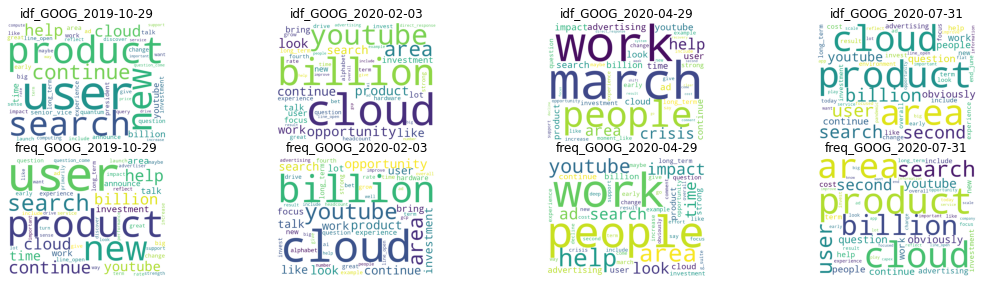

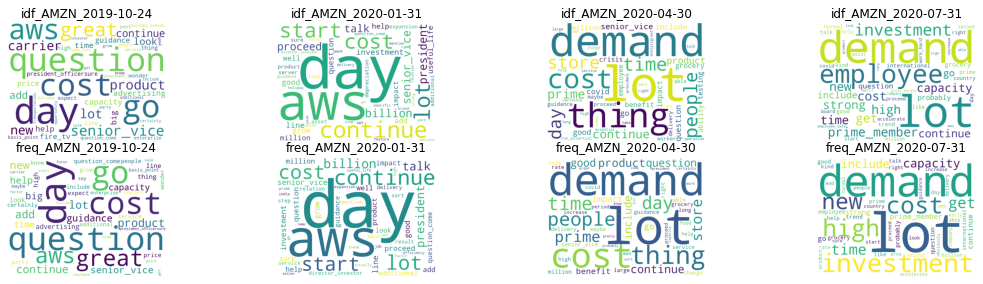

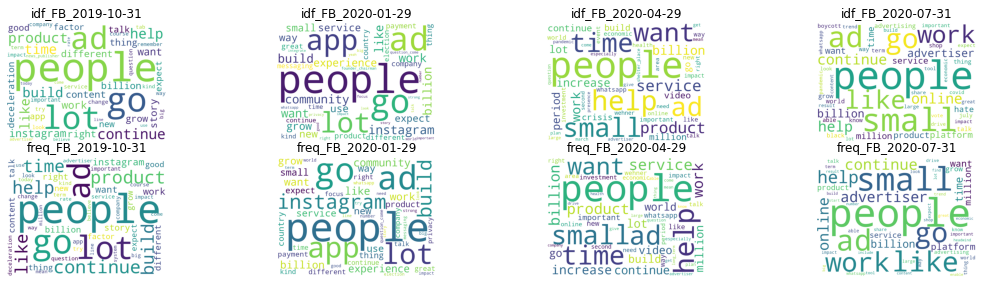

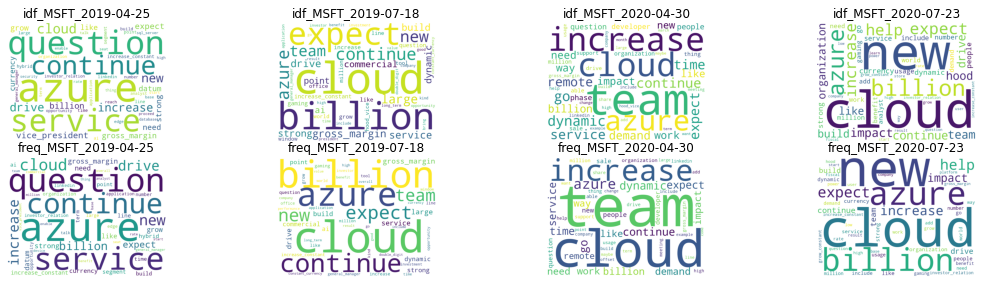

In [243]:
tickers = df['ticker'].unique().tolist()
wc = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 10)
wc2 = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 10)
docs_joined = []
num_tickers = len(tickers)
for ticker in tickers:
    
    sub_df = df.loc[df['ticker']==ticker]
    sub_df = sub_df.sort_values('call_date',ascending=True)
    docs = sub_df['words_ngrams'].apply(lambda x: " ".join(x)).tolist()
    dates = sub_df['call_date'].tolist()
    num_dates = len(dates)
    # tokenize and build vocab
    idf_vector = tfidf_vectorizer.fit_transform(docs)
    count_vector = count_vectorizer.fit_transform(docs)
    index=0
    fig = plt.figure(figsize=(15,15))
    for dt, doc in zip(dates, docs):
        docs_joined.extend(doc)
        
        df_idf = pd.DataFrame(idf_vector[index].T.toarray(), index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
        dict_idf_top50 = df_idf.sort_values(by=['idf_weights'],ascending=False)[:50].to_dict()['idf_weights']

        df_counter = pd.DataFrame(count_vector[index].T.toarray(), index=count_vectorizer.get_feature_names(), columns=["word_freq"])
        dict_counter_top50 = df_counter.sort_values(by=['word_freq'],ascending=False)[:50].to_dict()["word_freq"]
        
        plt.subplot(2*num_tickers, num_dates,index+1).set_title("idf_" + ticker + "_" + str(dt.date()))
        wc.generate_from_frequencies(dict_idf_top50)
        # plot the WordCloud image                        
        plt.imshow(wc)
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        
        plt.subplot(2*num_tickers, num_dates,index+num_dates+1).set_title("freq_" + ticker + "_" + str(dt.date()))
        wc2.generate_from_frequencies(dict_counter_top50)
        # plot the WordCloud image                        
        plt.imshow(wc2)
        plt.axis("off")
        plt.tight_layout(pad = 0) 
        index += 1

plt.show()  



/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


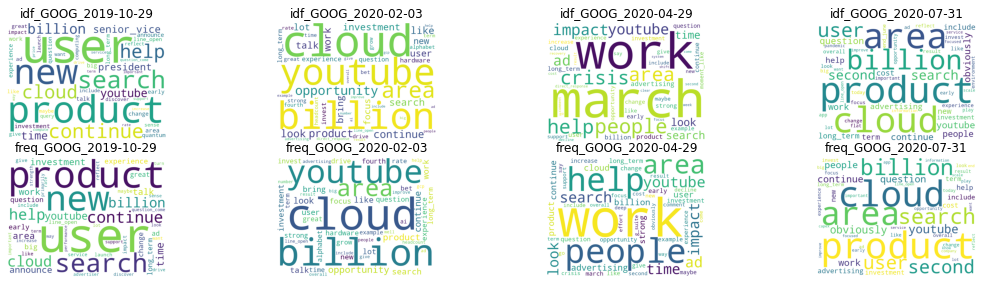

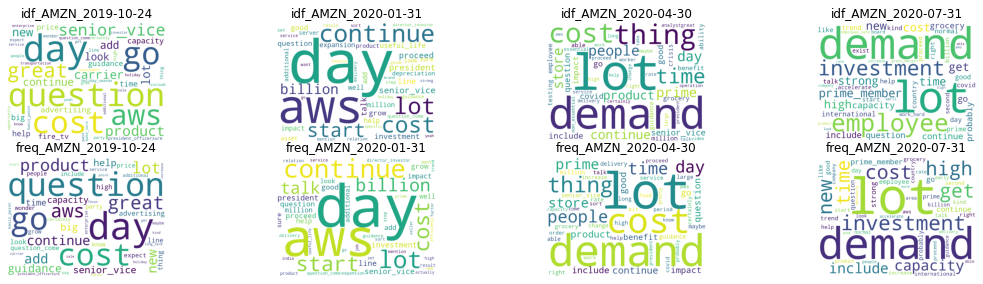

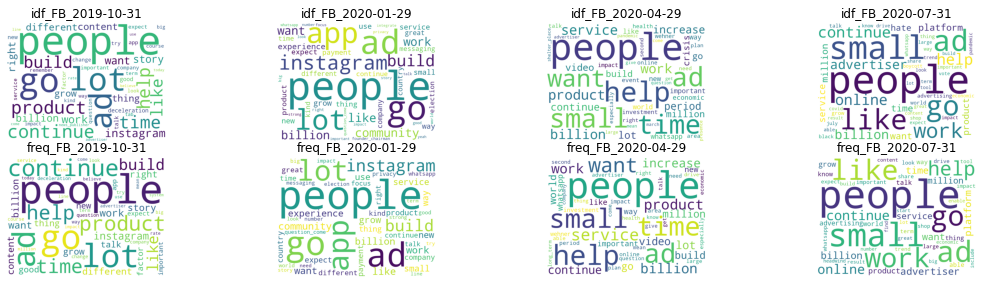

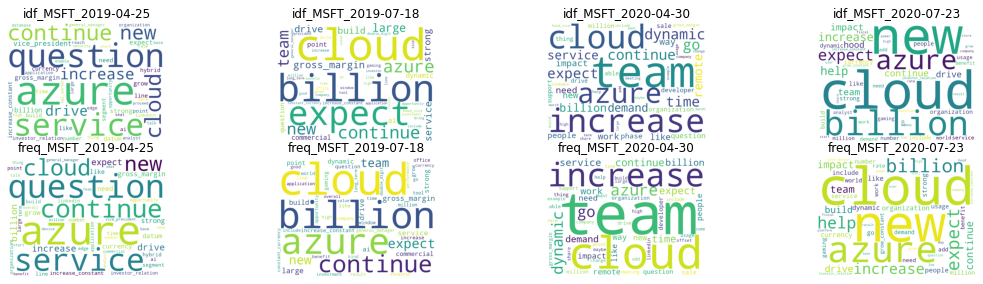

In [172]:
tickers = df['ticker'].unique().tolist()
wc = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 10)
wc2 = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 10)
docs_joined = []
num_tickers = len(tickers)
for ticker in tickers:
    
    sub_df = df.loc[df['ticker']==ticker]
    sub_df = sub_df.sort_values('call_date',ascending=True)
    docs = sub_df['words_ngrams'].apply(lambda x: " ".join(x)).tolist()
    dates = sub_df['call_date'].tolist()
    num_dates = len(dates)
    # tokenize and build vocab
    tfidf_vectorizer.fit(docs)
    count_vectorizer.fit(docs)
    index=1
    fig = plt.figure(figsize=(15,15))
    for dt, doc in zip(dates, docs):
        docs_joined.extend(doc)
        
        idf_vector = tfidf_vectorizer.transform([doc])        
        df_idf = pd.DataFrame(idf_vector.T.toarray(), index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
        #dict_idf_top50 = df_idf.loc[df_idf['idf_weights']>0].sort_values(by=['idf_weights'],ascending=True)[:50].to_dict()['idf_weights']
        dict_idf_top50 = df_idf.sort_values(by=['idf_weights'],ascending=False)[:50].to_dict()['idf_weights']

        count_vector = count_vectorizer.transform([doc])
        df_counter = pd.DataFrame(count_vector.T.toarray(), index=count_vectorizer.get_feature_names(), columns=["word_freq"])
        dict_counter_top50 = df_counter.sort_values(by=['word_freq'],ascending=False)[:50].to_dict()["word_freq"]
        
        plt.subplot(2*num_tickers, num_dates,index).set_title("idf_" + ticker + "_" + str(dt.date()))
        wc.generate_from_frequencies(dict_idf_top50)
        # plot the WordCloud image                        
        plt.imshow(wc)
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        
        plt.subplot(2*num_tickers, num_dates,index+num_dates).set_title("freq_" + ticker + "_" + str(dt.date()))
        wc2.generate_from_frequencies(dict_counter_top50)
        # plot the WordCloud image                        
        plt.imshow(wc2)
        plt.axis("off")
        plt.tight_layout(pad = 0) 
        index += 1

plt.show()  



In [96]:
sub_df = df.iloc[0:3]
sub_df.to_csv('df_call_transcripts.csv', columns=['ticker','call_date','words_ngrams'])


In [97]:
from collections import Counter
def remove_non_important_words(df_row, column_name, custom_exlude_list, max_freq=0.01, min_freq=0.0001):
    print(f"Processing {df_row['ticker']}, date: {df_row['call_date']}")
    num_words = len(df_row[column_name])
    max_word_count = round(max_freq*num_words)
    min_word_count = round(min_freq*num_words)
    # print(max_word_count, min_word_count)
    counter = Counter(df_row[column_name])
    # word list higher than given frequency or below certain frequency
    non_imp_words = [k for k,v in counter.most_common() if v > max_word_count or v <= min_word_count]
    # remove the non-important (high freq, loq freq)
    filtered_word_list = [w for w in df_row[column_name] if w not in non_imp_words and w not in custom_exlude_list]
    # print(num_words, len(filtered_word_list))
    return filtered_word_list


In [98]:
custom_exlude_list=[]
df['words_ngrams_filtered'] = df.apply(remove_non_important_words, \
                                            args=('words_ngrams', custom_exlude_list, 0.1, 0.001, ), axis=1)

Processing GOOG, date: 2020-07-31 00:00:00
Processing GOOG, date: 2020-04-29 00:00:00
Processing GOOG, date: 2020-02-03 00:00:00
Processing GOOG, date: 2019-10-29 00:00:00
Processing AMZN, date: 2020-07-31 00:00:00
Processing AMZN, date: 2020-04-30 00:00:00
Processing AMZN, date: 2020-01-31 00:00:00
Processing AMZN, date: 2019-10-24 00:00:00
Processing FB, date: 2020-07-31 00:00:00
Processing FB, date: 2020-04-29 00:00:00
Processing FB, date: 2020-01-29 00:00:00
Processing FB, date: 2019-10-31 00:00:00
Processing MSFT, date: 2020-07-23 00:00:00
Processing MSFT, date: 2020-04-30 00:00:00
Processing MSFT, date: 2019-07-18 00:00:00
Processing MSFT, date: 2019-04-25 00:00:00


In [99]:
texts = df['words_ngrams_filtered'].tolist()
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [100]:
ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=5)

In [101]:
ldamodel.show_topics()

[(0,
  '0.013*"people" + 0.012*"continue" + 0.011*"product" + 0.011*"service" + 0.011*"new" + 0.010*"expect" + 0.010*"look" + 0.010*"year" + 0.010*"lot" + 0.010*"go"'),
 (1,
  '0.019*"people" + 0.014*"continue" + 0.014*"go" + 0.014*"product" + 0.013*"lot" + 0.013*"year" + 0.011*"new" + 0.010*"ad" + 0.010*"build" + 0.010*"time"'),
 (2,
  '0.016*"people" + 0.014*"year" + 0.013*"help" + 0.013*"go" + 0.012*"time" + 0.012*"continue" + 0.010*"work" + 0.009*"question" + 0.009*"product" + 0.009*"increase"'),
 (3,
  '0.015*"people" + 0.011*"continue" + 0.011*"question" + 0.011*"year" + 0.011*"drive" + 0.011*"new" + 0.011*"service" + 0.010*"time" + 0.010*"increase" + 0.010*"expect"'),
 (4,
  '0.016*"continue" + 0.012*"new" + 0.012*"people" + 0.012*"help" + 0.012*"year" + 0.011*"lot" + 0.011*"work" + 0.010*"product" + 0.009*"ad" + 0.009*"talk"')]

In [102]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.009895 -0.001959       1        1  28.437576
2      0.001187 -0.005447       2        1  26.971723
3      0.010350  0.000337       3        1  17.558225
4     -0.003207  0.005756       4        1  14.696679
0      0.001564  0.001314       5        1  12.335798, topic_info=          Term        Freq       Total Category  logprob  loglift
59      expect  203.000000  203.000000  Default  30.0000  30.0000
118        new  283.000000  283.000000  Default  29.0000  29.0000
37    continue  354.000000  354.000000  Default  28.0000  28.0000
163    service  243.000000  243.000000  Default  27.0000  27.0000
104       look  198.000000  198.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
22       build   21.617619  210.568807   Topic5  -5.0393  -0.1836
48       drive   21.646182  214.775137   Topic5  -5.0379  -0.2021
178       talk   20.895100  195.386429   Topic5  -5.0733  -0.1428
172     strong   19.253734  165.613270   Topic5  -5.1551  -0.0593
198  year_year   19.535962  195.129704   Topic5  -5.1405  -0.2087

[419 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
387       1  0.239603  accelerate
387       2  0.383365  accelerate
387       3  0.143762  accelerate
387       4  0.095841  accelerate
387       5  0.095841  accelerate
...     ...       ...         ...
198       1  0.210117   year_year
198       2  0.312613   year_year
198       3  0.199867   year_year
198       4  0.174243   year_year
198       5  0.102496   year_year

[1259 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 5, 1])

In [103]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv('loughran_mcdonald_master_dic_2016.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
print(f'before any sentiment_df.shape {sentiment_df.shape}')
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]
print(f'after any sentiment_df.shape {sentiment_df.shape}')

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


before any sentiment_df.shape (85221, 7)
after any sentiment_df.shape (3926, 7)


In [104]:
word_list = nlp(" ".join(sentiment_df['word'].str.lower()))
word_lemmas = []
for word in word_list:
    # print(word.text, word.lemma_)
    word_lemmas.append(word.lemma_)

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
sentiment_df.insert(loc=7, column='lemma', value=word_lemmas)

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:

# Apply the same preprocessing to these words as the 10-k words
sentiment_df = sentiment_df.drop_duplicates('lemma')
print(f'after drop_duplicates sentiment_df.shape {sentiment_df.shape}')
print()
print()
print(f'sentiment_df[sentiments].sum()-->\n{sentiment_df[sentiments].sum()}')
print('shape is sentiment * words i.e. rows will have sentiment classification and columns are list of words with those sentiments')

after drop_duplicates sentiment_df.shape (2425, 8)


sentiment_df[sentiments].sum()-->
negative        1357
positive         242
uncertainty      200
litigious        608
constraining      89
interesting       59
dtype: int64
shape is sentiment * words i.e. rows will have sentiment classification and columns are list of words with those sentiments


/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
df = df.reindex(columns= df.columns.to_list() + sentiments)

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
def get_sentiment_info(df_row, sentiment_df):
    vector = sentiment_vectorizer.transform([" ".join(df_row['words_ngrams'])])
    return np.sum(vector.toarray())


/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
sentiment_vectorizer = CountVectorizer()
for sentiment in sentiments:
    sentiment_words = sentiment_df.loc[sentiment_df[sentiment],'lemma']
    sentiment_vectorizer.fit(sentiment_words)
    df[sentiment] = df.apply(get_sentiment_info, args=(sentiment_vectorizer, ), axis=1)

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


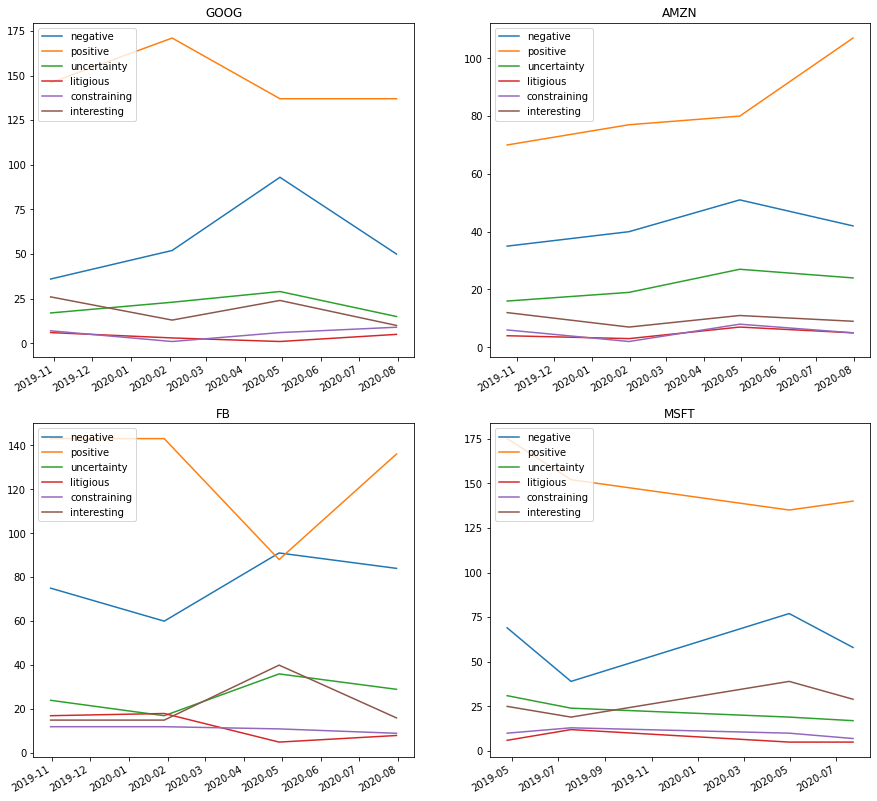

In [111]:
fig = plt.figure(figsize=(15, 15))
fig.autofmt_xdate()
tickers = df['ticker'].unique().tolist()
for index, ticker in enumerate(tickers):
    pos = 220 + index + 1 # to create fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223), fig.add_subplot(224)
    ax1 = fig.add_subplot(pos)
    sub_df = df.loc[df['ticker']==ticker,['call_date']+sentiments]
    sub_df = sub_df.sort_values('call_date',ascending=True)
    #sub_df['call_date'] = sub_df['call_date'].astype(str)
    ax1.plot(sub_df['call_date'], sub_df[sentiments])
    ax1.set_title(ticker)
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax1.legend(sentiments, loc='upper left')
plt.show()


In [231]:
tickers=['MSFT']
#df_all_tfidf = pd.DataFrame()
#df_all_counter = pd.DataFrame()
tfidf={}
counts={}
for ticker in tickers:
    
    sub_df = df.loc[df['ticker']==ticker]
    sub_df = sub_df.sort_values('call_date',ascending=True)
    docs = sub_df['words_ngrams'].apply(lambda x: " ".join(x)).tolist()
    dates = sub_df['call_date'].tolist()
    num_dates = len(dates)
    # tokenize and build vocab
    tfidf_vectorizer.fit(docs)
    count_vectorizer.fit(docs)
    for dt, doc in zip(dates, docs):
        
        idf_vector = tfidf_vectorizer.transform([doc])        
        count_vector = count_vectorizer.transform([doc])
        #print(idf_vector.T.toarray().shape,  idf_vector.T.toarray().flatten().shape, idf_vector.T.toarray().flatten())
        tfidf[str(dt.date())] = pd.Series(idf_vector.T.toarray().flatten())
        counts[str(dt.date())] = pd.Series(count_vector.T.toarray().flatten())
        #df_all_tfidf[dt.date()] = pd.DataFrame(data=idf_vector.T.toarray(), index=None)
        #df_all_counter[dt.date()] = pd.DataFrame(data=count_vector.T.toarray(), index=None)

df_all_tfidf = pd.DataFrame.from_dict(tfidf, orient='index').transpose()
df_all_tfidf['feature_names'] =tfidf_vectorizer.get_feature_names()
df_all_tfidf.set_index(['feature_names'])

df_all_counter = pd.DataFrame.from_dict(counts, orient='index').transpose()
df_all_counter['feature_names'] =count_vectorizer.get_feature_names()
df_all_counter.set_index(['feature_names'])


/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,2019-04-25,2019-07-18,2020-04-30,2020-07-23
feature_names,,,,
aarp,0,0,1,0
ability,5,1,2,2
able,2,4,16,3
absolute,0,1,0,1
absolutely,4,0,2,1
...,...,...,...,...
zeitgeist,0,0,1,0
zelnick,0,0,0,2
zero,0,1,3,1


In [232]:
df_all_tfidf.to_csv(ticker +'_tfidf.csv')
df_all_counter.to_csv(ticker +'_counter.csv')

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
%matplotlib inline
tickers = df['ticker'].unique().tolist()
wc = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 10)
# tickers=['MSFT']
docs_joined = []
for ticker in tickers:
    docs = df.loc[df['ticker']==ticker,'words_ngrams'].apply(lambda x: " ".join(x)).tolist()
    dates = df.loc[df['ticker']==ticker,'call_date'].tolist()
    # tokenize and build vocab
    tfidf_vectorizer.fit(docs)
    for dt, doc in zip(dates, docs):
        # print(dt, len(doc))
        #print(len(doc))
        docs_joined.extend(doc)
        vector = tfidf_vectorizer.transform([doc])
        # summarize encoded vector
        #print(vector.shape)
        #print(vector.toarray())
        df_idf = pd.DataFrame(vector.T.toarray(), index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
        dict_top50 = df_idf.sort_values(by=['idf_weights'],ascending=False)[:50].to_dict()['idf_weights']
        wc.generate_from_frequencies(dict_top50)
        # plot the WordCloud image                        
        plt.imshow(wc)
        plt.title(ticker + "_" + str(dt))
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show()    

In [ ]:

vectorizer = CountVectorizer()
docs_sentiment = {}
tickers=['GOOG']
for ticker in tickers:
    docs = df.loc[df['ticker']==ticker,'words_ngrams'].apply(lambda x: " ".join(x)).tolist()
    dates = df.loc[df['ticker']==ticker,'call_date'].tolist()
    for sentiment in sentiments:
        sentiment_words = sentiment_df.loc[sentiment_df[sentiment],'lemma']
        vectorizer.fit(sentiment_words)
        vector = vectorizer.transform(docs)
        print(ticker,sentiment, np.sum(vector.toarray()))
        # docs_sentiment[ticker] = vector.toarray()


In [241]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document. or is this is not the second document',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

#df_tfidf = pd.DataFrame(X[0].T.toarray(), index=vectorizer.get_feature_names(),columns=["idf_weights"])
df_tfidf = pd.DataFrame(X.T.toarray(), index=vectorizer.get_feature_names(),columns=list('ABCD'))

print(df_tfidf.sort_values(by=['C'],ascending=False))
print(df_tfidf.sort_values(by=['B'],ascending=False))

['and', 'document', 'first', 'is', 'not', 'one', 'or', 'second', 'the', 'third', 'this']
                 A         B         C         D
and       0.000000  0.000000  0.511849  0.000000
one       0.000000  0.000000  0.511849  0.000000
third     0.000000  0.000000  0.511849  0.000000
is        0.384085  0.414048  0.267104  0.384085
the       0.384085  0.276032  0.267104  0.384085
this      0.384085  0.276032  0.267104  0.384085
document  0.469791  0.506440  0.000000  0.469791
first     0.580286  0.000000  0.000000  0.580286
not       0.000000  0.264479  0.000000  0.000000
or        0.000000  0.264479  0.000000  0.000000
second    0.000000  0.528958  0.000000  0.000000
                 A         B         C         D
second    0.000000  0.528958  0.000000  0.000000
document  0.469791  0.506440  0.000000  0.469791
is        0.384085  0.414048  0.267104  0.384085
the       0.384085  0.276032  0.267104  0.384085
this      0.384085  0.276032  0.267104  0.384085
not       0.000000  0.264479 

/Users/anirudh/opt/anaconda3/envs/nlp10k/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from gensim import similarities
index = similarities.MatrixSimilarity(ldamodel[corpus])

In [ ]:
index

In [ ]:
doc1 = nlp("I like cats")
doc2 = nlp("I like dogs")
# Compare 2 documents
doc1.similarity(doc2)

In [90]:
text ="John wasn't the boy's behaviour was very aggressive. He was shouting all the time"
doc = nlp(text)
for word in doc:
    print(word.text, word.pos_, word.ent_type_, word.lemma_, word.is_stop)

John PROPN PERSON John False
was AUX  be True
n't PART  not True
the DET  the True
boy NOUN  boy False
's PART  's True
behaviour NOUN  behaviour False
was AUX  be True
very ADV  very True
aggressive ADJ  aggressive False
. PUNCT  . False
He PRON  -PRON- True
was AUX  be True
shouting VERB  shout False
all DET  all True
the DET  the True
time NOUN  time False


In [ ]:
from spacy.lemmatizer import Lemmatizer, ADJ, NOUN, VERB

lemmatizer = nlp.vocab.morphology.lemmatizer
lemmatizer('aggressively was', VERB)

In [ ]:
url = 'https://www.fool.com/earnings/call-transcripts/2020/04/29/alphabet-inc-goog-googl-q1-2020-earnings-call-tran.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2020/07/31/alphabet-inc-goog-googl-q2-2020-earnings-call-tran.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2020/02/03/alphabet-inc-goog-googl-q4-2019-earnings-call-tran.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2019/10/29/google-inc-googl-q3-2019-earnings-call-transcript.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2020/01/29/facebook-inc-fb-q4-2019-earnings-call-transcript.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2019/10/31/facebook-inc-fb-q3-2019-earnings-call-transcript.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2020/07/31/facebook-fb-q2-2020-earnings-call-transcript.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2020/04/29/facebook-inc-fb-q1-2020-earnings-call-transcript.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2020/07/31/amazon-amzn-q2-2020-earnings-call-transcript.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2020/04/30/amazoncom-inc-amzn-q1-2020-earnings-call-transcrip.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2020/01/31/amazoncom-inc-amzn-q4-2019-earnings-call-transcrip.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2019/10/24/amazoncom-inc-amzn-q3-2019-earnings-call-transcrip.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2019/04/25/microsoft-corp-msft-q3-2019-earnings-call-transcri.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2019/07/18/microsoft-corp-msft-q4-2019-earnings-call-transcri.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2020/07/23/microsoft-msft-q4-2020-earnings-call-transcript.aspx'
url = 'https://www.fool.com/earnings/call-transcripts/2020/04/30/microsoft-corp-msft-q3-2020-earnings-call-transcri.aspx'

In [ ]:
url_get =  requests.get(url)
soup = BeautifulSoup(url_get.text)

In [ ]:
local_path=download_dir + Path("microsoft-q1-2020-earnings-call-transcript.html")
with open(local_path,'w') as fh:
                fh.write(str(soup)) 

In [ ]:
h2_all = soup.find_all('h2')
for h2 in h2_all:
    #print(h2.prettify())
    print(h2)

In [ ]:
regex = re.compile(r'<h2>Prepared Remarks:</h2>\s*(\n*.*)\s*<h2>Call participants:</h2>',re.DOTALL)
matches = regex.finditer(str(soup))
for match in matches:
    # print(match)
    plain_text = BeautifulSoup(match.group(1), 'html.parser').get_text() # remove all the html
    # print(plain_text)

In [ ]:
local_path="./downloads/microsoft-q1-2020-earnings-call-transcript.txt"
with open(local_path,'w') as fh:
                fh.write(plain_text) 